In [56]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Add, Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [57]:
# Data Augmentation & Resizing to 299x299
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255  # Only rescaling for test data
)

In [58]:
train_generator = train_datagen.flow_from_directory(
    r"C:\Users\jaiag\Desktop\Postulate\celebdf+ff++\train",
    target_size=(299, 299),  # Resize from 128x128 to 299x299
    batch_size=32,
    class_mode='binary'
)

Found 11633 images belonging to 2 classes.


In [59]:
test_generator = test_datagen.flow_from_directory(
    r"C:\Users\jaiag\Desktop\Postulate\celebdf+ff++\test",
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

Found 2400 images belonging to 2 classes.


In [60]:
# CBAM Attention Module
def channel_attention(input_tensor, ratio=8):
    channel = int(input_tensor.shape[-1])
    shared_layer_one = Dense(channel // ratio, activation='relu')
    shared_layer_two = Dense(channel, activation='sigmoid')
    
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = Multiply()([input_tensor, cbam_feature])
    return cbam_feature

# Define Input
input_layer = Input(shape=(299, 299, 3))

# CNN with Attention
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = channel_attention(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = channel_attention(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = channel_attention(x)
x = MaxPooling2D(2,2)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification (Real vs Fake)

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 299, 299,  │        896 │ input_layer_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 299,  │        128 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 149, 149,  │     18,496 │ max_pooling2d_40… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │        256 │ conv2d_65[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 64)        │        576 │ dense_68[0][0],   │
│                     │                   │            │ dense_68[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 64)        │          0 │ dense_69[0][0],   │
│                     │                   │            │ dense_69[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 64)        │          0 │ add_30[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_30         │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Multiply)          │ 64)               │            │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 74, 74,    │          0 │ multiply_30[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 74, 74,    │     73,856 │ max_pooling2d_41… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat

 Total params: 478,393 (1.82 MB)

 Trainable params: 477,433 (1.82 MB)

 Non-trainable params: 960 (3.75 KB)

In [72]:
# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min', verbose=1)
checkpoint = ModelCheckpoint("3DCNN_CBAM.h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train Model
history_3DCNN = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks= [early_stopping,checkpoint],
    verbose=1
)


c:\Users\jaiag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5534 - loss: 1.8347
Epoch 1: val_loss improved from inf to 0.75239, saving model to 3DCNN_CBAM.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.5534 - loss: 1.8330 - val_accuracy: 0.5317 - val_loss: 0.7524
Epoch 2/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6278 - loss: 0.6712
Epoch 2: val_loss improved from 0.75239 to 0.63895, saving model to 3DCNN_CBAM.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.6278 - loss: 0.6712 - val_accuracy: 0.6854 - val_loss: 0.6390
Epoch 3/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6660 - loss: 0.6270
Epoch 3: val_loss did not improve from 0.63895
364/364 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.6661 - loss: 0.6270 - val_accuracy: 0.5383 - val_loss: 0.7267
Epoch 4/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6831 - loss: 0.6079
Epoch 4: val_loss did not improve from 0.63895
364/364 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.6831 - loss: 0.6079 - val_accuracy: 0.5871 - val_loss: 0.7388
Epoch 5/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7159 - loss: 0.5756
Epoch 5: val_loss improved from 0.63895 to 0.59625, saving model to 3DCNN_CBAM.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.7159 - loss: 0.5756 - val_accuracy: 0.7075 - val_loss: 0.5963
Epoch 6/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7480 - loss: 0.5414
Epoch 6: val_loss improved from 0.59625 to 0.59227, saving model to 3DCNN_CBAM.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.7480 - loss: 0.5414 - val_accuracy: 0.7542 - val_loss: 0.5923
Epoch 7/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7733 - loss: 0.5156
Epoch 7: val_loss did not improve from 0.59227
364/364 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.7733 - loss: 0.5156 - val_accuracy: 0.6558 - val_loss: 0.6658
Epoch 8/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7849 - loss: 0.4921
Epoch 8: val_loss improved from 0.59227 to 0.54555, saving model to 3DCNN_CBAM.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.7850 - loss: 0.4921 - val_accuracy: 0.7437 - val_loss: 0.5455
Epoch 9/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8105 - loss: 0.4509
Epoch 9: val_loss did not improve from 0.54555
364/364 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.8105 - loss: 0.4509 - val_accuracy: 0.7458 - val_loss: 0.5475
Epoch 10/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8279 - loss: 0.4277
Epoch 10: val_loss did not improve from 0.54555
364/364 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.8279 - loss: 0.4277 - val_accuracy: 0.6758 - val_loss: 0.6624
Epoch 11/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8358 - loss: 0.4078
Epoch 11: val_loss did not improve from 0.54555
364/364 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.8358 - loss: 0.4078 - val_accuracy: 0.7729 - val_loss: 0.5647
Epoch 12/50
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8544 - loss: 0.3701
Epoch 12: val_loss did not improve from 0.

In [73]:
import matplotlib.pyplot as plt 

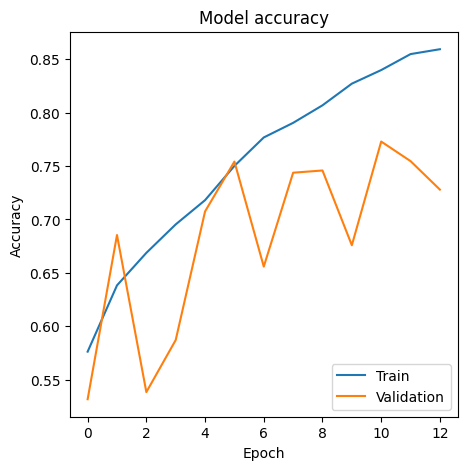

In [75]:
# FIRST
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history_3DCNN.history['accuracy'])
plt.plot(history_3DCNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

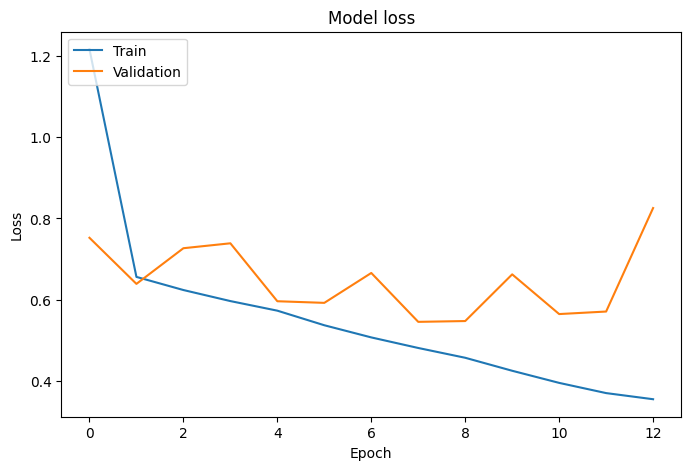

In [76]:
# FIRST
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history_3DCNN.history['loss'])
plt.plot(history_3DCNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 232ms/step


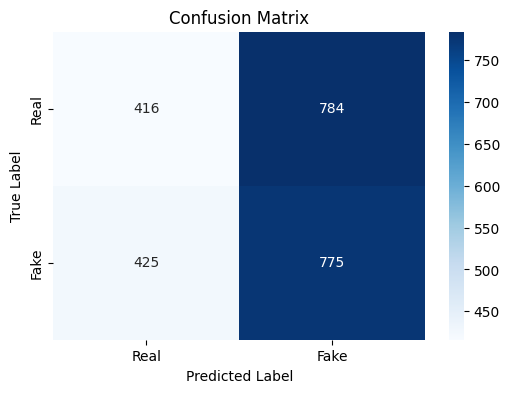

Classification Report:
               precision    recall  f1-score   support

        Real       0.49      0.35      0.41      1200
        Fake       0.50      0.65      0.56      1200

    accuracy                           0.50      2400
   macro avg       0.50      0.50      0.48      2400
weighted avg       0.50      0.50      0.48      2400



In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get True Labels
true_labels = test_generator.classes  # Actual labels from test data

# Predict Probabilities
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))


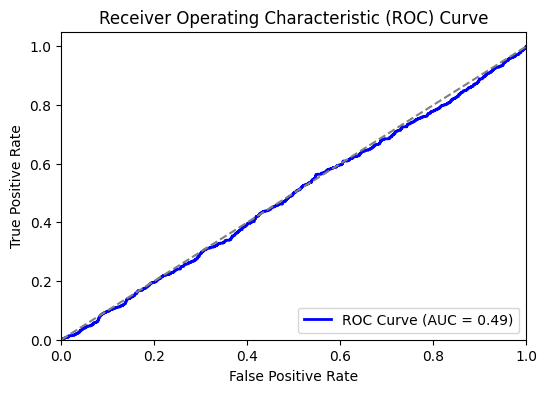

AUC Score: 0.4910


In [79]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUC Score: {roc_auc:.4f}")
